# Test rerun on the server

The `get_sample_TSV.nf` script has been executed on the following samples:

- `data/read_only/samples/processed/processed.AS22WG001.trio.genotype.norm.filt.soi.vcf.gz`
- `data/read_only/samples/processed/processed.AS22WG004.merge.family.vep.vcf.gz`
- `data/read_only/samples/processed/processed.AS22WG009.trio.genotype.norm.filt.soi.vcf.gz`

The command used for thisn run:
```
nextflow run get_sample_TSV.nf --gnomADByRegionDir data/pipeline_outputs/variants_gnomAD --DBXCLI dbxcli --uploadDir Nitzan_Gonen_lab/Joint_projects/WGS_on_DSD/data/pipeline_outputs/variants_gnomAD --VENV /home/dsi/toozig/.virtualenvs/deepBindEnv/bin/activate --MAX_REGIONS 10000 --REGION_SPLIT_SIZE 6000 --all_samples data/read_only/samples/processed/all_samples.txt --output_dir data/pipeline_outputs/variants_gnomAD --sample_file test_samples.txt --upload false --bed_file data/read_only/ATAC_seq/merged/merged_mATAC_hATAC_0507.bed  -params-file get_sample_TSV.json
```

This script performs several operations on the VCF files of each sample. It first adds the interval ID to each sample and removes variants that fall outside these intervals. The script then converts the modified VCF file into a TSV format and merges it with the gnomAD database. This is the process that generates the final output.

The final output can be found in- <br>
`/dsi/gonen-lab/shared_files/WGS_on_DSD/data/pipeline_outputs/variants_gnomAD/merged_mATAC_hATAC_0507/test_samples/merged_mATAC_hATAC_0507.test_samples.parquet`<br>
 

> note: the output is a parquet format file and not a standart format. the file afterward being processed by Roni script for QC


> The file was not upload to the cloud, since this is just a test




In [2]:
import pandas as pd
import numpy as np


In [3]:
samples_file = '/home/dsi/toozig/gonen-lab/users/toozig/projects/WGS_DSD-get_gnomAD/data/pipeline_outputs/variants_gnomAD/merged_mATAC_hATAC_0507/test_samples/merged_mATAC_hATAC_0507.test_samples.parquet'
df = pd.read_parquet(samples_file)
display(df.head())
print(f'there are total {len(df)} variants (rows) in the file\n describing {len(df.columns) // 4} samples')

,CHROM,POS,REF,ALT,FILTER,AF,AF_popmax,INTERVAL_ID,AS22WG001:GT,AS22WG001:DP,...,AS22WG009:GQ,AS22WG009:AB,AS22WG010:GT,AS22WG010:DP,AS22WG010:GQ,AS22WG010:AB,AS22WG011:GT,AS22WG011:DP,AS22WG011:GQ,AS22WG011:AB
0,chr1,629914,A,G,PASS,0.000042,0.000810,SE0,,-1,...,-1,0.000000,,-1,-1,0.00000,,-1,-1,0.000000
1,chr1,629990,G,A,PASS,0.004910,0.038635,SE0,,-1,...,-1,0.000000,,-1,-1,0.00000,,-1,-1,0.000000
2,chr1,633887,G,A,AS_VQSR,0.447185,0.671532,GR.PG.SE1,,-1,...,-1,0.000000,,-1,-1,0.00000,,-1,-1,0.000000
3,chr1,634112,T,C,AS_VQSR;InbreedingCoeff,0.581946,0.687968,GR.PG.SE1,0/1,81,...,99,0.569767,0/1,46,99,0.73913,0/1,46,99,0.347826
4,chr1,634321,T,C,PASS,0.000008,0.000217,GR.PG.SE1,,-1,...,-1,0.000000,,-1,-1,0.00000,,-1,-1,0.000000


there are total 303424 variants (rows) in the file
 describing 13 samples


In [4]:
def get_per_sample(df):
    samples_vars = df[df.columns[df.columns.str.contains('GT')]].replace('0/0', '').replace('',np.nan).notna().sum(axis=0)
    return samples_vars
    
GT_df = df[df.columns[df.columns.str.contains('GT')]]
samples_vars = df[df.columns[df.columns.str.contains('GT')]].replace('0/0', '').replace('',np.nan).notna().sum(axis=0)

novel_df = df[df.AF_popmax == -1]
novel_per_sample = novel_df[novel_df.columns[novel_df.columns.str.contains('GT')]].replace('0/0', '').replace('',np.nan).notna().sum(axis=0)

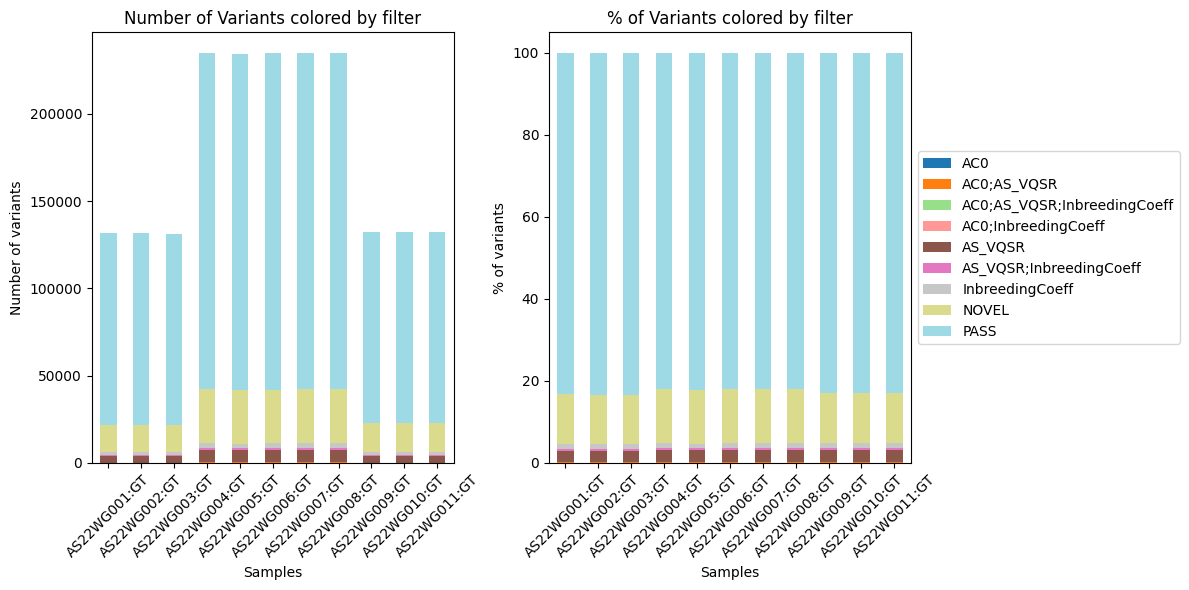

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def manipulate_data(df, GT_df):
    filter_df = df[['FILTER'] + GT_df.columns.tolist()] 
    filter_df.loc[:,"FILTER"] = filter_df.FILTER.replace(' ','NOVEL')
    metl_df = filter_df.melt(id_vars='FILTER')
    metl_df = metl_df.replace(' ',np.nan).dropna()

    sum_df = metl_df.drop(columns='value').groupby('variable').FILTER.value_counts().unstack()
    sum_df.loc[:,'total'] = sum_df.sum(axis=1)

    precent_df = sum_df.div(sum_df.total, axis=0) * 100

    return sum_df, precent_df


def plot_data(df, ax, title, ylabel, yticks=None, legend=True):
    df.drop(columns='total').plot(kind='bar', stacked=True, ax=ax,  colormap='tab20')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        ax.get_legend().remove()
    ax.set_title(title)
    ax.set_xlabel('Samples')
    ax.set_ylabel(ylabel)
    if yticks is not None:
        ax.set_yticks(yticks)

def plot_variant_distribution(sum_df, precent_df):
    # Create a figure with two subplots
    fig, axs = plt.subplots(1,2, figsize=(12, 6))

    plot_data(sum_df, axs[0], 'Number of Variants colored by filter', 'Number of variants', legend=False)
    plot_data(precent_df, axs[1], '% of Variants colored by filter', '% of variants', np.arange(0, 110, 20))

    plt.tight_layout()
    plt.show()


sum_df, precent_df = manipulate_data(df, GT_df)
plot_variant_distribution(sum_df, precent_df)

In [ ]:
def plot_data(df, ax, title, ylabel, yticks=None, legend=True):
    df.drop(columns='total').plot(kind='bar', stacked=True, ax=ax,  colormap='tab20')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        ax.get_legend().remove()
    ax.set_title(title)
    ax.set_xlabel('Samples')
    ax.set_ylabel(ylabel)
    if yticks is not None:
        ax.set_yticks(yticks)

def plot_variant_distribution(sum_df, precent_df):
    # Create a figure with two subplots
    fig, axs = plt.subplots(2, figsize=(6, 6))

    plot_data(sum_df, axs[0], 'Number of Variants colored by filter', 'Number of variants', legend=False)
    plot_data(precent_df, axs[1], '% of Variants colored by filter', '% of variants', np.arange(0, 110, 20))

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_990872/3773055024.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnomad_pss['AF_popmax'] = df.AF_popmax
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


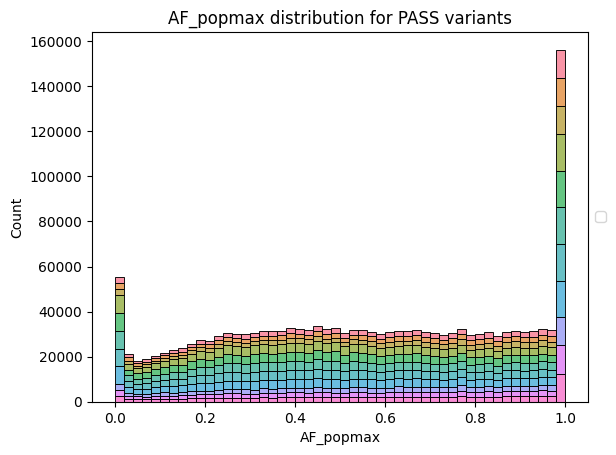

In [18]:

gnomAD_df = df[df.AF_popmax != -1][['FILTER'] + GT_df.columns.tolist()]
gnomad_pss = gnomAD_df[gnomAD_df.FILTER == 'PASS']
gnomad_pss['AF_popmax'] = df.AF_popmax
import seaborn as sns 
# plot violin plot of the AF_popmax distribution for PASS variants
melt_df = gnomad_pss.melt(id_vars=['AF_popmax','FILTER']).replace('0/0', '')
empty = melt_df.value.values[0]
melt_df = melt_df.replace(empty, np.nan)
melt_df = melt_df.dropna()
# plot histogram of AF_popmax, make it stacked and color by the 'variable' column
plot = sns.histplot(melt_df, x='AF_popmax', hue='variable', multiple='stack', bins=50)
plot.set_title('AF_popmax distribution for PASS variants')
# move the legend to the side and show it
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


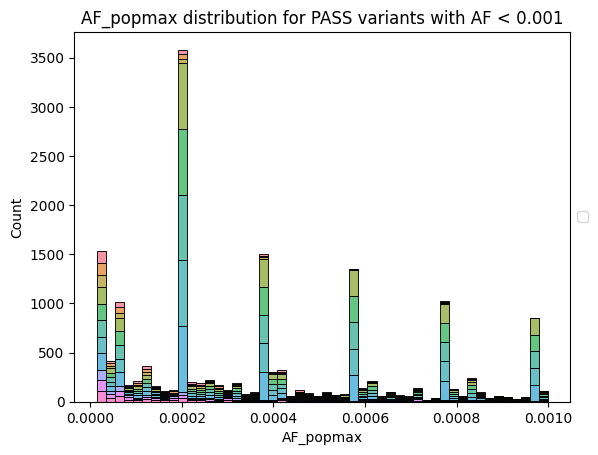

In [19]:
low_AF = melt_df[melt_df.AF_popmax < 0.001]
plot = sns.histplot(low_AF, x='AF_popmax', hue='variable', multiple='stack', bins=50)
plot.set_title('AF_popmax distribution for PASS variants with AF < 0.001')
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [32]:
old_path = 'merged_mATAC_hATAC_0507.all_samples.parquet'
df2 = pd.read_parquet(old_path)
df2 = df2[['FILTER', 'AF_popmax'] + GT_df.columns.tolist()]
metl_df2 = df2.melt(id_vars=['FILTER','AF_popmax'])
metl_df2 = metl_df2.replace(' ',np.nan).replace('0/0',np.nan).replace('0|0',np.nan).dropna()

In [33]:
metl_df2.value.value_counts()

value
0/1    742213
1/1    559426
0|1    106258
1|1     73596
1/0     18709
1|0        84
Name: count, dtype: int64

In [34]:
metl_df2.groupby('variable').FILTER.describe()

,count,unique,top,freq
variable,,,,
AS22WG001:GT,128657,6,PASS,121879
AS22WG002:GT,101856,6,PASS,97129
AS22WG003:GT,101915,6,PASS,97049
AS22WG004:GT,167086,8,PASS,160163
AS22WG005:GT,165497,8,PASS,159356
AS22WG006:GT,165669,8,PASS,159429
AS22WG007:GT,167296,8,PASS,160576
AS22WG008:GT,167688,8,PASS,160853
AS22WG009:GT,129604,6,PASS,122629


In [26]:
df3 = df[['FILTER', 'AF_popmax'] + GT_df.columns.tolist()]
metl_df3 = df3.melt(id_vars=['FILTER','AF_popmax'])
metl_df3 = metl_df3.replace(' ',np.nan).dropna()

In [35]:
metl_df3.value.value_counts()

value
0/1    763405
1/1    567320
0/0    366839
1/0     16969
Name: count, dtype: int64

In [27]:
metl_df3.groupby('variable').FILTER.describe()

,count,unique,top,freq
variable,,,,
AS22WG001:GT,115793,6,PASS,109608
AS22WG002:GT,115728,6,PASS,109571
AS22WG003:GT,115672,6,PASS,109542
AS22WG004:GT,203946,8,PASS,192705
AS22WG005:GT,203543,8,PASS,192475
AS22WG006:GT,203781,8,PASS,192599
AS22WG007:GT,204034,8,PASS,192777
AS22WG008:GT,203926,8,PASS,192723
AS22WG009:GT,116090,6,PASS,109714


In [4]:
import yaml
import shlex

def command_to_yaml(command, output_file):
    # Split the command into parts
    parts = shlex.split(command)

    # Create a dictionary to hold the variables and their values
    data = {}

    # Iterate over the parts of the command
    for i in range(len(parts)):
        # If the part starts with '--', it's a flag
        if parts[i].startswith('--'):
            # The next part is the value for this flag
            if i + 1 < len(parts) and not parts[i + 1].startswith('--'):
                data[parts[i].lstrip('--')] = parts[i + 1]

    # Add the full command as a variable
    data['full_command'] = command
    print(data)
    # Write the data to a YAML file
    with open(output_file, 'w') as f:
        yaml.dump(data, f)

# Usage
command = "nextflow run get_sample_TSV.nf --gnomADByRegionDir data/pipeline_outputs/variants_gnomAD --DBXCLI dbxcli --uploadDir Nitzan_Gonen_lab/Joint_projects/WGS_on_DSD/data/pipeline_outputs/variants_gnomAD --VENV /home/dsi/toozig/.virtualenvs/deepBindEnv/bin/activate --MAX_REGIONS 10000 --REGION_SPLIT_SIZE 6000 --all_samples data/read_only/samples/processed/all_samples.txt --output_dir data/pipeline_outputs/variants_gnomAD --sample_file test_samples.txt --upload false --bed_file data/read_only/ATAC_seq/merged/merged_mATAC_hATAC_0507.bed -params-file get_sample_TSV.json"
from pprint import pprint
pprint(command_to_yaml(command, 'output.yml'))

{'gnomADByRegionDir': 'data/pipeline_outputs/variants_gnomAD', 'DBXCLI': 'dbxcli', 'uploadDir': 'Nitzan_Gonen_lab/Joint_projects/WGS_on_DSD/data/pipeline_outputs/variants_gnomAD', 'VENV': '/home/dsi/toozig/.virtualenvs/deepBindEnv/bin/activate', 'MAX_REGIONS': '10000', 'REGION_SPLIT_SIZE': '6000', 'all_samples': 'data/read_only/samples/processed/all_samples.txt', 'output_dir': 'data/pipeline_outputs/variants_gnomAD', 'sample_file': 'test_samples.txt', 'upload': 'false', 'bed_file': 'data/read_only/ATAC_seq/merged/merged_mATAC_hATAC_0507.bed', 'full_command': 'nextflow run get_sample_TSV.nf --gnomADByRegionDir data/pipeline_outputs/variants_gnomAD --DBXCLI dbxcli --uploadDir Nitzan_Gonen_lab/Joint_projects/WGS_on_DSD/data/pipeline_outputs/variants_gnomAD --VENV /home/dsi/toozig/.virtualenvs/deepBindEnv/bin/activate --MAX_REGIONS 10000 --REGION_SPLIT_SIZE 6000 --all_samples data/read_only/samples/processed/all_samples.txt --output_dir data/pipeline_outputs/variants_gnomAD --sample_file t